In [ ]:
import csv
import math
import random
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

data = []
with open('DATA.csv', newline='', encoding='utf-8') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        data.append(row)

for i in range(1, len(data)):
    grade = int(data[i][-1])
    data[i][-1] = 1 if grade >= 3 else 0

In [ ]:
n_features = len(data[0]) - 2

selected_features_count = math.isqrt(n_features)

random.seed(time.time())
selected_features_indices = random.sample(range(1, n_features + 1), selected_features_count)

selected_features = [data[0][i] for i in selected_features_indices]
print("Выбранные признаки:", selected_features)

Выбранные признаки: ['5', '22', '7', '19', '4']


In [ ]:
def calculate_entropy(labels):
    total = len(labels)
    counts = {label: labels.count(label) for label in set(labels)}
    entropy = -sum((count / total) * math.log2(count / total) for count in counts.values())
    return entropy

def calculate_gini(labels):
    total = len(labels)
    counts = {label: labels.count(label) for label in set(labels)}
    gini = 1 - sum((count / total) ** 2 for count in counts.values())
    return gini

def information_gain(data, labels, feature_index):
    total_gini = calculate_gini(labels)
    values = [row[feature_index] for row in data]
    subsets = {value: [] for value in set(values)}

    for row, label in zip(data, labels):
        subsets[row[feature_index]].append(label)

    weighted_gini = sum((len(subset) / len(labels)) * calculate_gini(subset) for subset in subsets.values())
    return total_gini - weighted_gini

def build_tree(data, labels, features):
    if len(set(labels)) == 1:
        return {"label": labels[0], "prob": labels.count(1) / len(labels)}

    if not features:
        return {"label": max(set(labels), key=labels.count), "prob": labels.count(1) / len(labels)}

    gains = [information_gain(data, labels, f) for f in features]
    best_feature = features[gains.index(max(gains))]

    tree = {"feature": best_feature, "branches": {}}
    feature_values = set(row[best_feature] for row in data)
    for value in feature_values:
        subset_data = [row for row in data if row[best_feature] == value]
        subset_labels = [label for row, label in zip(data, labels) if row[best_feature] == value]
        tree["branches"][value] = build_tree(subset_data, subset_labels, [f for f in features if f != best_feature])

    return tree


In [ ]:
def predict_proba(tree, row):
    if "label" in tree:
        return tree["prob"]
    feature = tree["feature"]
    value = row[feature]
    if value in tree["branches"]:
        return predict_proba(tree["branches"][value], row)
    else:
        return max(set(train_labels), key=train_labels.count)

random.seed(time.time())
random.shuffle(data[1:])
split_index = len(data[1:]) // 2
train_data = data[1:split_index+1]
test_data = data[split_index+1:]

train_features = [row[1:-1] for row in train_data]
train_labels = [int(row[-1]) for row in train_data]

decision_tree = build_tree(train_features, train_labels, selected_features_indices)
print("Построенное дерево решений:", decision_tree)

test_features = [row[1:-1] for row in test_data]
test_labels = [int(row[-1]) for row in test_data] 

predicted_proba = [predict_proba(decision_tree, row) for row in test_features]

predictions = [1 if proba >= 0.5 else 0 for proba in predicted_proba]

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, pos_label=1)
recall = recall_score(test_labels, predictions, pos_label=1)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Построенное дерево решений: {'feature': 7, 'branches': {'2': {'feature': 4, 'branches': {'1': {'label': 0, 'prob': 0.0}, '2': {'feature': 5, 'branches': {'1': {'label': 1, 'prob': 1.0}, '2': {'feature': 22, 'branches': {'3': {'label': 1, 'prob': 1.0}, '1': {'feature': 19, 'branches': {'1': {'label': 0, 'prob': 0.125}}}, '2': {'label': 0, 'prob': 0.0}}}}}}}, '5': {'label': 0, 'prob': 0.0}, '3': {'feature': 22, 'branches': {'1': {'feature': 5, 'branches': {'1': {'label': 0, 'prob': 0.0}, '2': {'feature': 19, 'branches': {'1': {'feature': 4, 'branches': {'2': {'label': 0, 'prob': 0.4}}}, '2': {'label': 0, 'prob': 0.0}}}}}, '2': {'label': 0, 'prob': 0.0}}}, '4': {'feature': 5, 'branches': {'1': {'label': 0, 'prob': 0.0}, '2': {'label': 1, 'prob': 1.0}}}, '1': {'feature': 19, 'branches': {'1': {'feature': 5, 'branches': {'1': {'feature': 4, 'branches': {'1': {'label': 1, 'prob': 1.0}, '2': {'feature': 22, 'branches': {'1': {'label': 0, 'prob': 0.5}}}}}, '2': {'feature': 4, 'branches': {'1':

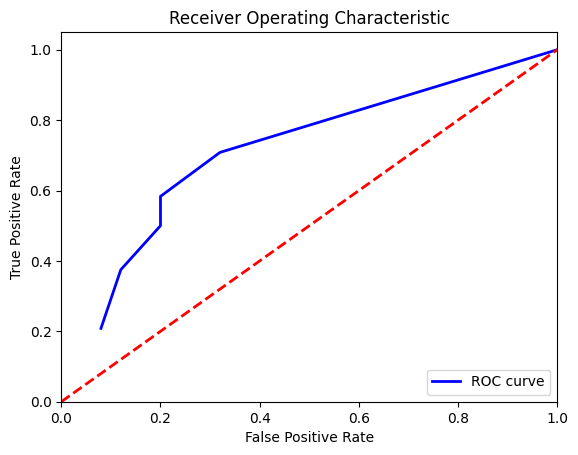

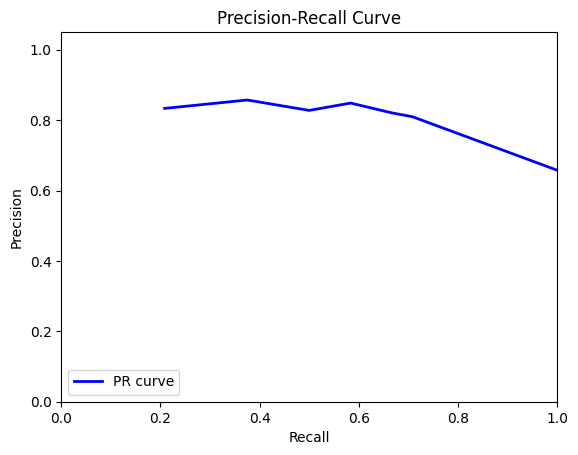

In [ ]:
def calculate_roc(true_labels, predicted_scores):
    thresholds = sorted(set(predicted_scores), reverse=True)
    tpr_list = []
    fpr_list = []

    for threshold in thresholds:
        predicted_labels = [1 if score >= threshold else 0 for score in predicted_scores]
        tp = sum((t == 1 and p == 1) for t, p in zip(true_labels, predicted_labels))
        fp = sum((t == 0 and p == 1) for t, p in zip(true_labels, predicted_labels))
        fn = sum((t == 1 and p == 0) for t, p in zip(true_labels, predicted_labels))
        tn = sum((t == 0 and p == 0) for t, p in zip(true_labels, predicted_labels))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return fpr_list, tpr_list

def calculate_pr(true_labels, predicted_scores):
    thresholds = sorted(set(predicted_scores), reverse=True)
    precision_list = []
    recall_list = []

    for threshold in thresholds:
        predicted_labels = [1 if score >= threshold else 0 for score in predicted_scores]
        tp = sum((t == 1 and p == 1) for t, p in zip(true_labels, predicted_labels))
        fp = sum((t == 0 and p == 1) for t, p in zip(true_labels, predicted_labels))
        fn = sum((t == 1 and p == 0) for t, p in zip(true_labels, predicted_labels))

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)

    return precision_list, recall_list

def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_pr_curve(precision, recall):
    plt.figure()
    plt.plot(recall, precision, color='blue', lw=2, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

fpr, tpr = calculate_roc(test_labels, predicted_proba)
plot_roc_curve(fpr, tpr)

precision_list, recall_list = calculate_pr(test_labels, predicted_proba)
plot_pr_curve(precision_list, recall_list)
